# Datium Data Science Assessment – Section A
**Goal:** Predict vehicle sale prices (`Sold_Amount`).

This notebook follows a structured ML workflow:
1. Data loading & initial inspection
2. Exploratory Data Analysis (EDA)
3. Feature engineering & encoding
4. Model experimentation with MLflow tracking
5. Model evaluation & diagnostics
6. Final model selection

In [1]:
import sys, os, pathlib
sys.path.insert(0, os.path.join(os.getcwd(), '..', 'src'))

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import shap
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from trainer import VehiclePriceTrainer, BANNED_FEATURES, TARGET

pd.set_option('display.max_columns', 60)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_theme(style='whitegrid', palette='muted')

SEED = 42
DATA_DIR = '../data'

## 1. Data Loading

In [2]:
train_raw = pd.read_csv(f'{DATA_DIR}/train.rpt', sep='\t', low_memory=False, encoding='utf-8-sig')
test_raw  = pd.read_csv(f'{DATA_DIR}/test.rpt',  sep='\t', low_memory=False, encoding='utf-8-sig')

print(f'Train shape: {train_raw.shape}')
print(f'Test  shape: {test_raw.shape}')
train_raw.head(3)

Train shape: (50704, 130)
Test  shape: (11488, 130)


,Make,Model,MakeCode,FamilyCode,YearGroup,MonthGroup,SequenceNum,Description,CurrentRelease,ImportFlag,LimitedEdition,Series,SeriesModelYear,BadgeDescription,BadgeSecondaryDescription,BodyStyleDescription,BodyConfigDescription,WheelBaseConfig,Roofline,ExtraIdentification,DriveDescription,DriveCode,GearTypeDescription,GearLocationDescription,GearNum,DoorNum,EngineSize,EngineDescription,Cylinders,FuelTypeDescription,...,CO2Urban,CO2ExtraUrban,FuelUrban,FuelExtraurban,FuelCombined,EmissionStandard,MaxEthanolBlend,AncapRating,VFactsClass,VFactsSegment,VFactsPrice,IsPPlateApproved,AverageKM,GoodKM,AvgWholesale,AvgRetail,GoodWholesale,GoodRetail,TradeMin,TradeMax,PrivateMax,NewPrice,Colour,Branch,SaleCategory,Sold_Date,Compliance_Date,Age_Comp_Months,KM,Sold_Amount
0,Holden,Commodore,HOLD,COMMODO,2008,0,0,VE Omega Sedan 4dr. Auto 4sp 3.6i,F,L,F,VE,NaN,Omega,NaN,Sedan,NaN,NaN,NaN,NaN,Rear Wheel Drive,RWD,Automatic,Floor,4.00,4,3565,3.6,6,Petrol - Unleaded ULP,...,NaN,NaN,NaN,NaN,10.90,NaN,NaN,4.00,Passenger,Large,< $70K,T,230.00,140.00,2500.00,5000.00,3850.00,6450.00,2100.00,3500.00,5500.00,34790.00,White,Perth (WA),Auction,2015-11-03 00:00:00.000,02/2008,93.00,227878.00,2000.00
1,Holden,Commodore,HOLD,COMMODO,1993,7,41,VR Executive Wagon 5dr. Auto 4sp 3.8i,F,L,F,VR,NaN,Executive,NaN,Wagon,NaN,NaN,NaN,NaN,Rear Wheel Drive,RWD,Automatic,Floor,4.00,5,3791,3.8,6,Petrol - Unleaded ULP,...,NaN,NaN,12.00,7.60,9.20,NaN,NaN,NaN,Passenger,Large,< $70K,T,600.00,360.00,NaN,NaN,NaN,2250.00,NaN,NaN,2000.00,27978.00,Red,Belmore (NSW),Auction,2000-10-18 00:00:00.000,08/1993,86.00,153091.00,6800.00
2,Toyota,RAV4,TOYO,RAV4,2012,0,6,ACA33R MY12 CV Wagon 5dr Man 5sp 4x4 2.4i,F,L,F,ACA33R,MY12,CV,NaN,Wagon,NaN,NaN,NaN,NaN,4X4 On Demand,4XO,Manual,Floor,5.00,5,2362,2.4,4,Petrol - Unleaded ULP,...,NaN,NaN,NaN,NaN,9.10,NaN,NaN,4.00,SUV,Medium,< $60K,T,130.00,80.00,12450.00,15450.00,14150.00,17450.00,10900.00,12700.00,15800.00,31990.00,040 - Glacier White (T),Sunshine (VIC),Dealer Only Auction,2014-02-05 00:00:00.000,10/2012,16.00,27374.00,22900.00


## 2. Data Understanding & Quality Checks

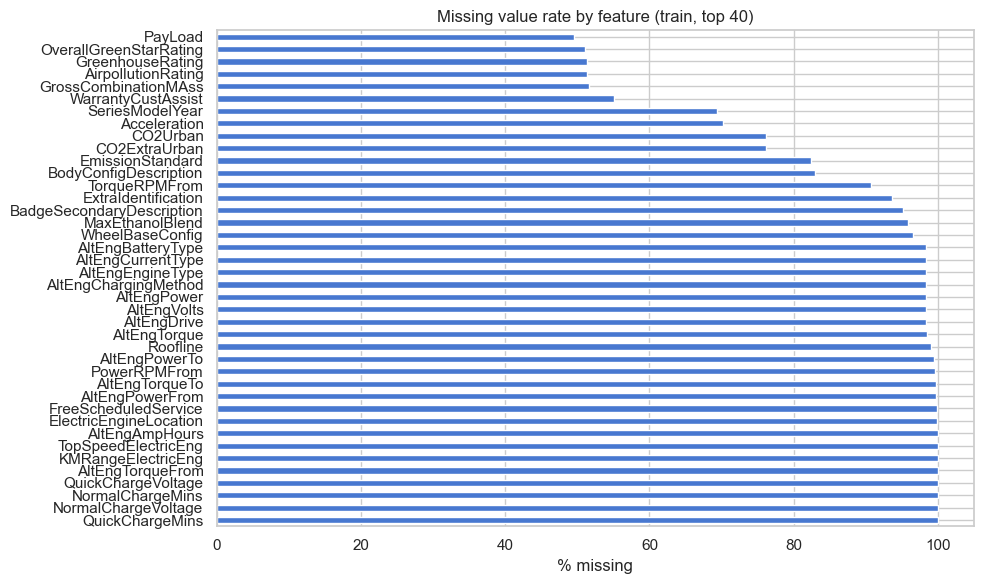

Columns with >50% missing: 39
Columns with >90% missing: 28


In [3]:
# ---- missing values ----
missing = train_raw.isnull().mean().sort_values(ascending=False)
missing_pct = (missing * 100).round(1)

fig, ax = plt.subplots(figsize=(10, 6))
missing_pct[missing_pct > 0].head(40).plot(kind='barh', ax=ax)
ax.set_title('Missing value rate by feature (train, top 40)')
ax.set_xlabel('% missing')
plt.tight_layout()
plt.savefig('../logs/missing_values.png', dpi=120)
plt.show()

print(f'Columns with >50% missing: {(missing_pct > 50).sum()}')
print(f'Columns with >90% missing: {(missing_pct > 90).sum()}')

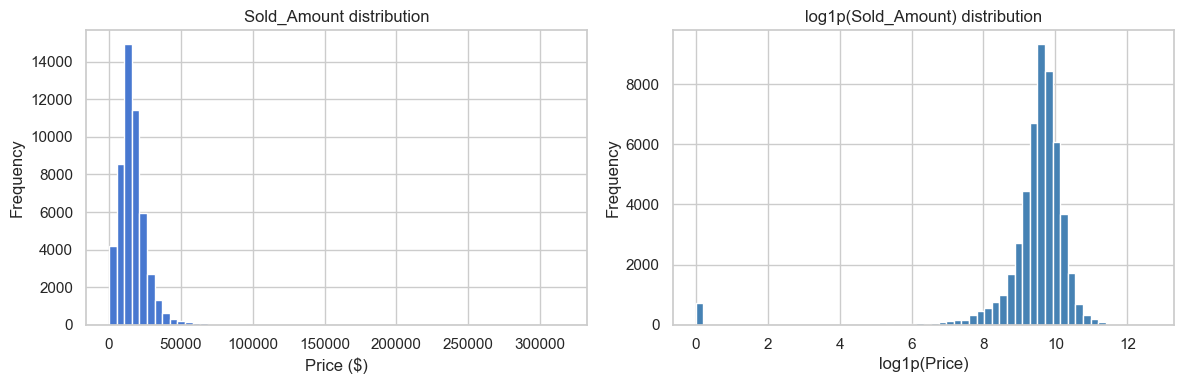

count    50700.00
mean     16401.72
std      10312.03
min          0.00
25%      10500.00
50%      15000.00
75%      20425.00
max     317000.00
Name: Sold_Amount, dtype: float64


In [4]:
# ---- target distribution ----
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

train_raw[TARGET].dropna().plot(kind='hist', bins=60, ax=axes[0])
axes[0].set_title('Sold_Amount distribution')
axes[0].set_xlabel('Price ($)')

np.log1p(train_raw[TARGET].dropna()).plot(kind='hist', bins=60, ax=axes[1], color='steelblue')
axes[1].set_title('log1p(Sold_Amount) distribution')
axes[1].set_xlabel('log1p(Price)')

plt.tight_layout()
plt.savefig('../logs/target_distribution.png', dpi=120)
plt.show()

print(train_raw[TARGET].describe())

In [5]:
# ---- outlier flag ----
q1, q99 = train_raw[TARGET].quantile([0.05, 0.95])
outliers = ((train_raw[TARGET] < q1) | (train_raw[TARGET] > q99)).sum()
print(f'Rows outside 1st–99th percentile: {outliers} ({outliers/len(train_raw)*100:.1f}%)')
print(f'1st pct: ${q1:,.0f}   99th pct: ${q99:,.0f}')

Rows outside 1st–99th percentile: 5002 (9.9%)
1st pct: $3,400   99th pct: $32,800


In [6]:
# ---- duplicate check ----
print(f'Duplicate rows: {train_raw.duplicated().sum()}')

# ---- NULL string check (common in .rpt exports) ----
null_str_cols = [c for c in train_raw.columns if (train_raw[c] == 'NULL').any()]
print(f'Columns containing literal "NULL" string: {len(null_str_cols)}')

Duplicate rows: 0
Columns containing literal "NULL" string: 0


## 3. Feature Engineering

In [7]:
# Australian market brand tier mapping
LUXURY_BRANDS = {
    'Mercedes-Benz', 'BMW', 'Audi', 'Lexus', 'Porsche', 'Maserati',
    'Ferrari', 'Lamborghini', 'Bentley', 'Rolls-Royce', 'Jaguar',
    'Land Rover', 'Volvo', 'Cadillac', 'Infiniti', 'Genesis',
    'Alfa Romeo', 'Lotus', 'McLaren', 'Aston Martin',
}
BUDGET_BRANDS = {
    'Daewoo', 'Chery', 'MG', 'LDV', 'Foton', 'Haval', 'GWM',
    'Suzuki', 'Daihatsu', 'Smart', 'Ssangyong', 'Proton',
}

# Columns that are exact code-aliases, zero-variance, or unique identifiers — drop them
REDUNDANT_COLS = [
    # Strict 1-to-1 bijections (code version of a description column)
    'MakeCode',           # duplicate of Make
    'FamilyCode',         # duplicate of Model
    'DriveCode',          # duplicate of DriveDescription
    'EngineDescription',  # rounded version of EngineSize (less precise)
    # Near-duplicate physical measurement (r=0.99, keep TareMass — AU standard)
    'KerbWeight',
    # Zero-variance across the full dataset (single constant value, zero signal)
    'CurrentRelease',
    'ImportFlag',
    'EngineCycleDescription',
    'EngineLocation',
    # Unique-per-vehicle identifiers — target encoding these memorises individual
    # car prices rather than learning a generalised signal (severe overfitting risk)
    'VIN',
    'EngineNum',
    # Free-text composite of Make+Model+Series+Badge — fully redundant with those cols
    'Description',
]

HIGH_MISS_COLS = []   # populated on first train call
KM_CAP = None         # populated on first train call


def preprocess(df: pd.DataFrame, is_train: bool = True) -> pd.DataFrame:
    df = df.copy()

    # ── Replace literal NULL strings ──────────────────────────────────
    df.replace('NULL', np.nan, inplace=True)

    # ── Filter junk sale prices (train only) ──────────────────────────
    if is_train and TARGET in df.columns:
        before = len(df)
        df = df[df[TARGET] >= 500].copy()
        print(f'  Removed {before - len(df)} rows with Sold_Amount < $500')

    # ── Drop banned columns ───────────────────────────────────────────
    df.drop(columns=[c for c in BANNED_FEATURES if c in df.columns], inplace=True)

    # ── Drop redundant/constant/identifier columns ────────────────────
    df.drop(columns=[c for c in REDUNDANT_COLS if c in df.columns], inplace=True)

    # ── Drop high-missing columns (>70%) ─────────────────────────────
    if is_train:
        global HIGH_MISS_COLS
        HIGH_MISS_COLS = df.columns[df.isnull().mean() > 0.70].tolist()
    df.drop(columns=[c for c in HIGH_MISS_COLS if c in df.columns], inplace=True)

    # ── Date features ─────────────────────────────────────────────────
    for col in ['Sold_Date', 'Compliance_Date']:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    if 'Sold_Date' in df.columns:
        df['Sold_Year']         = df['Sold_Date'].dt.year
        df['Sold_Month']        = df['Sold_Date'].dt.month
        df['Sold_Quarter']      = df['Sold_Date'].dt.quarter
        df['Is_End_Of_Quarter'] = df['Sold_Month'].isin([3, 6, 9, 12]).astype(int)

    # ── Vehicle age at sale ───────────────────────────────────────────
    if 'YearGroup' in df.columns and 'Sold_Date' in df.columns:
        df['Age_At_Sale'] = (
            df['Sold_Date'].dt.year
            - pd.to_numeric(df['YearGroup'], errors='coerce')
        )

    # ── KM: cap outliers + high-KM flag ──────────────────────────────
    if 'KM' in df.columns:
        df['KM'] = pd.to_numeric(df['KM'], errors='coerce')
        if is_train:
            global KM_CAP
            KM_CAP = df['KM'].quantile(0.99)
        df['Is_High_KM'] = (df['KM'] > KM_CAP).astype(int)
        df['KM'] = df['KM'].clip(upper=KM_CAP)

    if 'Age_Comp_Months' in df.columns:
        df['Age_Comp_Months'] = pd.to_numeric(df['Age_Comp_Months'], errors='coerce')
        df['KM_Per_Month'] = df['KM'] / df['Age_Comp_Months'].replace(0, np.nan)

    # ── Engine size ───────────────────────────────────────────────────
    if 'EngineSize' in df.columns:
        df['EngineSize'] = pd.to_numeric(df['EngineSize'], errors='coerce')

    # ── NewPrice features ─────────────────────────────────────────────
    if 'NewPrice' in df.columns:
        df['NewPrice'] = pd.to_numeric(df['NewPrice'], errors='coerce')
        df['NewPrice_log'] = np.log1p(df['NewPrice'])
        if 'KM' in df.columns:
            df['KM_Per_NewPrice_K'] = df['KM'] / (df['NewPrice'] / 1000).replace(0, np.nan)

    # ── Brand tier ───────────────────────────────────────────────────
    if 'Make' in df.columns:
        df['Brand_Tier'] = df['Make'].apply(
            lambda m: 'luxury' if m in LUXURY_BRANDS
                      else ('budget' if m in BUDGET_BRANDS else 'mainstream')
        )

    # ── Drop raw date cols ────────────────────────────────────────────
    df.drop(columns=['Sold_Date', 'Compliance_Date'], errors='ignore', inplace=True)

    return df


HIGH_MISS_COLS = []
KM_CAP = None
train_proc = preprocess(train_raw, is_train=True)
test_proc  = preprocess(test_raw,  is_train=False)

print(f'Processed train shape: {train_proc.shape}')
print(f'Processed test  shape: {test_proc.shape}')
print(f'\nRedundant columns removed: {[c for c in REDUNDANT_COLS if c in train_raw.columns]}')

  Removed 828 rows with Sold_Amount < $500
Processed train shape: (49876, 87)
Processed test  shape: (11488, 87)

Redundant columns removed: ['MakeCode', 'FamilyCode', 'DriveCode', 'EngineDescription', 'KerbWeight', 'CurrentRelease', 'ImportFlag', 'EngineCycleDescription', 'EngineLocation', 'VIN', 'EngineNum', 'Description']


In [8]:
# ── Drop rows with missing target ────────────────────────────────────
train_clean = train_proc.dropna(subset=[TARGET]).copy()

# Log-transform target (reduces right-skew)
y_log = np.log1p(train_clean[TARGET])
X     = train_clean.drop(columns=[TARGET])

# ── Identify column types ─────────────────────────────────────────────
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
all_cat  = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Split categoricals by cardinality:
#   high-card  → TargetEncoder (learns mean log-price per category, no leakage)
#   low-card   → OrdinalEncoder
HIGH_CARD_THRESHOLD = 15
high_card_cols = [c for c in all_cat if X[c].nunique() > HIGH_CARD_THRESHOLD]
low_card_cols  = [c for c in all_cat if X[c].nunique() <= HIGH_CARD_THRESHOLD]

print(f'Numeric features             : {len(num_cols)}')
print(f'Low-cardinality (ordinal)    : {len(low_card_cols)}')
print(f'High-cardinality (target-enc): {len(high_card_cols)}')
print(f'\nHigh-card cols: {high_card_cols}')

X_train, X_val, y_train, y_val = train_test_split(
    X, y_log, test_size=0.2, random_state=SEED
)

Numeric features             : 53
Low-cardinality (ordinal)    : 17
High-cardinality (target-enc): 16

High-card cols: ['Make', 'Model', 'Series', 'SeriesModelYear', 'BadgeDescription', 'BodyStyleDescription', 'ModelCode', 'BuildCountryOriginDescription', 'FrontTyreSize', 'RearTyreSize', 'FrontRimDesc', 'RearRimDesc', 'WarrantyCustAssist', 'VFactsPrice', 'Colour', 'Branch']


## 4. Preprocessing Pipeline

In [9]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler()),
])

# Low-cardinality → ordinal integers
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

# High-cardinality → target (mean log-price) encoding, fitted per CV fold — no leakage
target_enc_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder(target_type='continuous', smooth='auto')),
])

preprocessor = ColumnTransformer([
    ('num',        numeric_transformer,    num_cols),
    ('cat',        categorical_transformer, low_card_cols),
    ('target_enc', target_enc_transformer, high_card_cols),
], remainder='drop')

print('Preprocessor ready.')
print(f'  {len(num_cols)} numeric  |  {len(low_card_cols)} ordinal  |  {len(high_card_cols)} target-encoded')

Preprocessor ready.
  53 numeric  |  17 ordinal  |  16 target-encoded


## 5. Model Experiments with MLflow Tracking

In [10]:
# Absolute path — MLflow UI will always find these runs
MLRUNS_DIR = str(pathlib.Path('..').resolve() / 'logs' / 'mlruns')
mlflow.set_tracking_uri(MLRUNS_DIR)
print(f'MLflow tracking URI: {MLRUNS_DIR}')

MODELS = {
    'Ridge': Ridge(alpha=10.0),
    'RandomForest': RandomForestRegressor(
        n_estimators=200, max_depth=15, n_jobs=-1, random_state=SEED,
    ),
    'XGBoost': XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        n_jobs=-1, random_state=SEED, verbosity=0,
    ),
    'LightGBM': LGBMRegressor(
        n_estimators=500, learning_rate=0.05, num_leaves=63,
        subsample=0.8, colsample_bytree=0.8,
        n_jobs=-1, random_state=SEED, verbose=-1,
    ),
}

results = {}

for name, estimator in MODELS.items():
    print(f'\n===== {name} =====')
    pipe = Pipeline([('pre', preprocessor), ('model', estimator)])
    trainer = VehiclePriceTrainer(
        pipeline=pipe,
        experiment_name='vehicle_price_v2',
        cv_folds=5,
        models_dir='../models',
    )
    trainer.fit(
        X_train, y_train,
        X_val=X_val, y_val=y_val,
        run_name=name,
        extra_tags={'model_type': name, 'version': 'v2_enhanced'},
    )
    val_metrics = trainer.evaluate(X_val, y_val)
    results[name] = val_metrics

results_df = pd.DataFrame(results).T
print('\n--- Validation Results Summary ---')
print(results_df.sort_values('MAE'))

2026-02-23 18:29:51,738  INFO  Starting 5-fold cross-validation …


MLflow tracking URI: /Users/abdelsalmhamdi/Documents/Company Assessments /pickel/datium-assessment/logs/mlruns

===== Ridge =====


2026-02-23 18:29:57,049  INFO  CV  MAE=0.15±0.00  RMSE=0.23±0.00  R2=0.8685±0.0021
2026-02-23 18:29:57,050  INFO  Fitting on full training set …
2026-02-23 18:29:57,492  INFO  Val  MAE=0.15  RMSE=0.23  R2=0.8719  sMAPE=1.63%
2026/02/23 18:29:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 18:29:57 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html
2026-02-23 18:29:59,548  INFO  Run e852ad645f6841169a5efe7cab193f9a finished.  Model saved to ../models/Ridge.pkl.
2026-02-23 18:29:59,589  INFO    MAE    0.1496
2026-02-23 18:29:59,589  INFO    RMSE   0.2287
2026-02-23 18:29:59,589  INFO    R2     0.8719
2026-02-23 


===== RandomForest =====


2026-02-23 18:32:17,229  INFO  CV  MAE=0.13±0.00  RMSE=0.20±0.01  R2=0.8957±0.0042
2026-02-23 18:32:17,231  INFO  Fitting on full training set …
2026-02-23 18:32:28,854  INFO  Val  MAE=0.13  RMSE=0.21  R2=0.8934  sMAPE=1.43%
2026/02/23 18:32:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 18:32:29 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html
2026-02-23 18:32:31,391  INFO  Run 9cfc8284fa71460c93cfcb8d5fba35d1 finished.  Model saved to ../models/RandomForest.pkl.
2026-02-23 18:32:31,490  INFO    MAE    0.1312
2026-02-23 18:32:31,490  INFO    RMSE   0.2086
2026-02-23 18:32:31,491  INFO    R2     0.8934
2026


===== XGBoost =====


2026-02-23 18:32:40,502  INFO  CV  MAE=0.11±0.00  RMSE=0.18±0.01  R2=0.9216±0.0041
2026-02-23 18:32:40,503  INFO  Fitting on full training set …
2026-02-23 18:32:42,276  INFO  Val  MAE=0.11  RMSE=0.18  R2=0.9199  sMAPE=1.22%
2026/02/23 18:32:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 18:32:42 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html
2026-02-23 18:32:44,198  INFO  Run 2a5963c12c0f4b5e91ab99a38a479624 finished.  Model saved to ../models/XGBoost.pkl.
2026-02-23 18:32:44,247  INFO    MAE    0.1116
2026-02-23 18:32:44,247  INFO    RMSE   0.1807
2026-02-23 18:32:44,248  INFO    R2     0.9199
2026-02-2


===== LightGBM =====


2026-02-23 18:34:04,195  INFO  CV  MAE=0.11±0.00  RMSE=0.18±0.01  R2=0.9223±0.0035
2026-02-23 18:34:04,197  INFO  Fitting on full training set …
2026-02-23 18:34:11,199  INFO  Val  MAE=0.11  RMSE=0.18  R2=0.9213  sMAPE=1.19%
2026/02/23 18:34:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 18:34:11 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html
2026-02-23 18:34:13,415  INFO  Run 98806daf5fef4c81aeed24b85bf3ce62 finished.  Model saved to ../models/LightGBM.pkl.
2026-02-23 18:34:13,499  INFO    MAE    0.1087
2026-02-23 18:34:13,500  INFO    RMSE   0.1791
2026-02-23 18:34:13,500  INFO    R2     0.9213
2026-02-


--- Validation Results Summary ---
              MAE  RMSE   R2  sMAPE
LightGBM     0.11  0.18 0.92   1.19
XGBoost      0.11  0.18 0.92   1.22
RandomForest 0.13  0.21 0.89   1.43
Ridge        0.15  0.23 0.87   1.63


## 5b. Hyperparameter Tuning with Optuna (LightGBM)

Running Optuna for LightGBM (5 trials) …


  0%|          | 0/5 [00:00<?, ?it/s]


Best CV MAE (log-space): 0.1094
Best params:
{'n_estimators': 761, 'learning_rate': 0.030757141585777453, 'num_leaves': 49, 'max_depth': 12, 'min_child_samples': 31, 'subsample': 0.8871760338325092, 'colsample_bytree': 0.6191751721117584, 'reg_alpha': 0.00922231265208952, 'reg_lambda': 0.0003119020730493141}


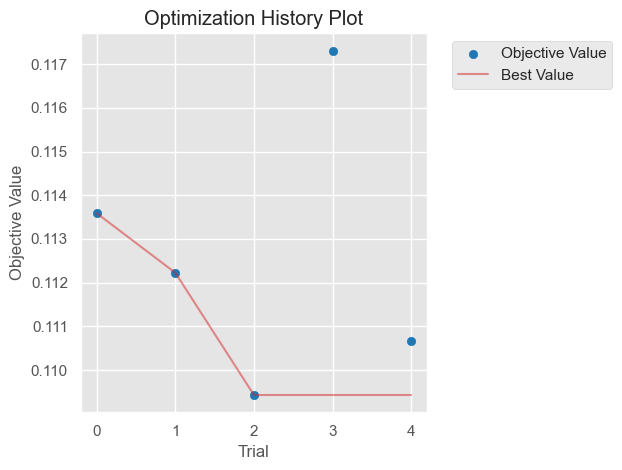

In [12]:
def objective_lgbm(trial):
    params = {
        'n_estimators':      trial.suggest_int  ('n_estimators',      300, 1200),
        'learning_rate':     trial.suggest_float('learning_rate',      0.01, 0.15, log=True),
        'num_leaves':        trial.suggest_int  ('num_leaves',         31, 255),
        'max_depth':         trial.suggest_int  ('max_depth',          4, 12),
        'min_child_samples': trial.suggest_int  ('min_child_samples',  10, 100),
        'subsample':         trial.suggest_float('subsample',          0.5, 1.0),
        'colsample_bytree':  trial.suggest_float('colsample_bytree',   0.5, 1.0),
        'reg_alpha':         trial.suggest_float('reg_alpha',          1e-4, 10.0, log=True),
        'reg_lambda':        trial.suggest_float('reg_lambda',         1e-4, 10.0, log=True),
        'n_jobs': -1, 'random_state': SEED, 'verbose': -1,
    }
    pipe = Pipeline([
        ('pre',   preprocessor),
        ('model', LGBMRegressor(**params)),
    ])
    kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
    scores = cross_val_score(
        pipe, X_train, y_train,
        cv=kf, scoring='neg_mean_absolute_error', n_jobs=1,
    )
    return -scores.mean()


print('Running Optuna for LightGBM (5 trials) …')
study = optuna.create_study(direction='minimize', study_name='lgbm_tuning')
study.optimize(objective_lgbm, n_trials=5, show_progress_bar=True)

best_lgbm_params = study.best_params
print(f'\nBest CV MAE (log-space): {study.best_value:.4f}')
print(f'Best params:\n{best_lgbm_params}')

fig = optuna.visualization.matplotlib.plot_optimization_history(study)
plt.tight_layout()
plt.savefig('../logs/optuna_history.png', dpi=120)
plt.show()

## 5c. Ensemble: Tuned LightGBM + XGBoost

In [13]:
from trainer import regression_metrics

# ── Build tuned pipelines ─────────────────────────────────────────────
tuned_lgbm_pipe = Pipeline([
    ('pre',   preprocessor),
    ('model', LGBMRegressor(**best_lgbm_params, verbose=-1)),
])
xgb_pipe = Pipeline([
    ('pre',   preprocessor),
    ('model', MODELS['XGBoost']),
])

tuned_lgbm_pipe.fit(X_train, y_train)
xgb_pipe.fit(X_train, y_train)

# ── Weighted average (weights ∝ val R²) ──────────────────────────────
lgbm_r2 = results_df.loc['LightGBM', 'R2']
xgb_r2  = results_df.loc['XGBoost',  'R2']
w_lgbm  = lgbm_r2 / (lgbm_r2 + xgb_r2)
w_xgb   = xgb_r2  / (lgbm_r2 + xgb_r2)
print(f'Ensemble weights  →  LightGBM: {w_lgbm:.3f}  XGBoost: {w_xgb:.3f}')

val_pred_ens = (
    w_lgbm * tuned_lgbm_pipe.predict(X_val)
    + w_xgb * xgb_pipe.predict(X_val)
)

ens_metrics = regression_metrics(y_val.values, val_pred_ens)
print('\nEnsemble validation metrics:')
for k, v in ens_metrics.items():
    print(f'  {k}: {v:.4f}')

# ── Log to MLflow ─────────────────────────────────────────────────────
with mlflow.start_run(run_name='Ensemble_LGB_XGB'):
    mlflow.set_tag('model_type', 'ensemble')
    mlflow.set_tag('version', 'v2_enhanced')
    mlflow.log_param('w_lgbm', round(w_lgbm, 3))
    mlflow.log_param('w_xgb',  round(w_xgb, 3))
    for k, v in ens_metrics.items():
        mlflow.log_metric(f'val_{k}', round(v, 4))

results['Ensemble'] = ens_metrics
results_df = pd.DataFrame(results).T
print('\n─── Full Results Comparison ────────────────────────────')
print(results_df[['MAE', 'RMSE', 'R2', 'sMAPE']].sort_values('MAE'))

Ensemble weights  →  LightGBM: 0.500  XGBoost: 0.500

Ensemble validation metrics:
  MAE: 0.1089
  RMSE: 0.1784
  R2: 0.9220
  sMAPE: 1.1922

─── Full Results Comparison ────────────────────────────
              MAE  RMSE   R2  sMAPE
LightGBM     0.11  0.18 0.92   1.19
Ensemble     0.11  0.18 0.92   1.19
XGBoost      0.11  0.18 0.92   1.22
RandomForest 0.13  0.21 0.89   1.43
Ridge        0.15  0.23 0.87   1.63


## 6. Model Diagnostics

In [14]:
# Use best BASE model for diagnostics (exclude Ensemble — not in MODELS dict)
base_results = results_df.loc[results_df.index.isin(MODELS.keys())]
best_name = base_results['MAE'].idxmin()
print(f'Best base model: {best_name}')

best_pipe = Pipeline([('pre', preprocessor), ('model', MODELS[best_name])])
best_pipe.fit(X_train, y_train)

val_pred_log = best_pipe.predict(X_val)
val_pred     = np.expm1(val_pred_log)
val_true     = np.expm1(y_val.values)

Best base model: LightGBM


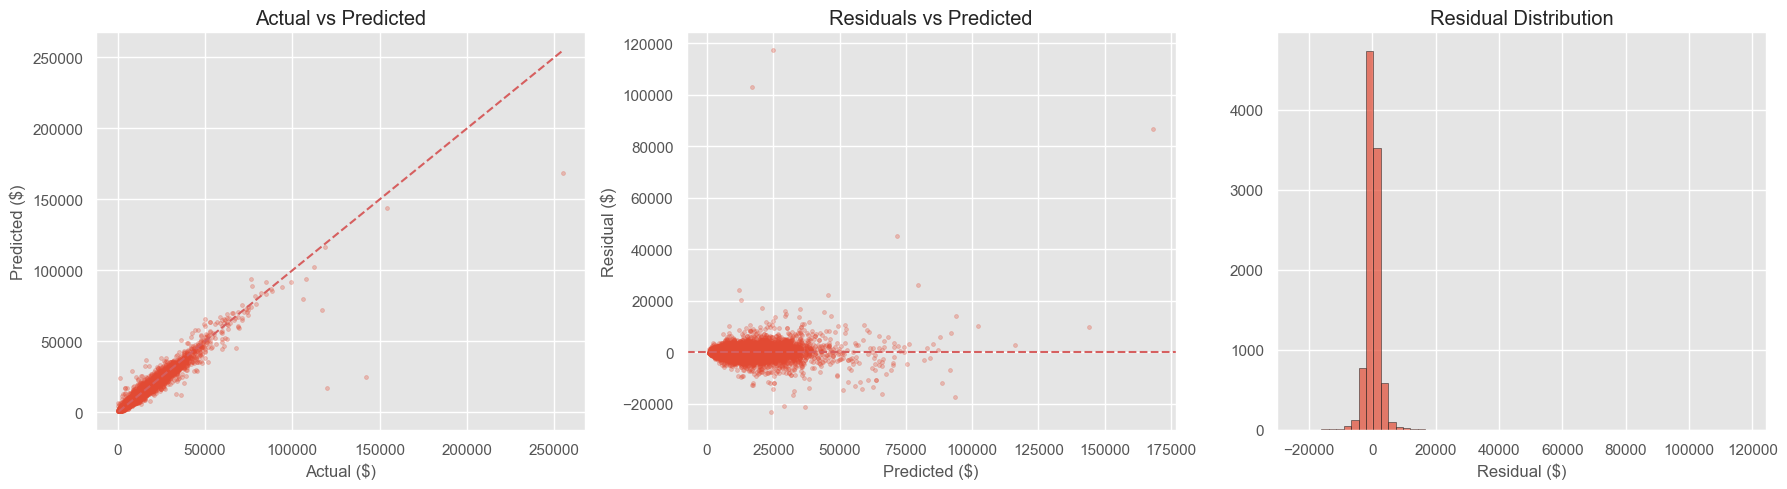

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# -- Actual vs Predicted --
axes[0].scatter(val_true, val_pred, alpha=0.3, s=8)
mn, mx = val_true.min(), val_true.max()
axes[0].plot([mn, mx], [mn, mx], 'r--')
axes[0].set_xlabel('Actual ($)')
axes[0].set_ylabel('Predicted ($)')
axes[0].set_title('Actual vs Predicted')

# -- Residuals --
residuals = val_true - val_pred
axes[1].scatter(val_pred, residuals, alpha=0.3, s=8)
axes[1].axhline(0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted ($)')
axes[1].set_ylabel('Residual ($)')
axes[1].set_title('Residuals vs Predicted')

# -- Residual distribution --
axes[2].hist(residuals, bins=60, edgecolor='k', alpha=0.7)
axes[2].set_xlabel('Residual ($)')
axes[2].set_title('Residual Distribution')

plt.tight_layout()
plt.savefig('../logs/diagnostics.png', dpi=120)
plt.show()

Error by price bucket:
        MAPE  Count
bucket             
<5k    50.70    630
5-10k  16.10   1514
10-20k  8.20   5146
20-40k  7.40   2473
40-80k  9.30    197
>80k   20.50     16


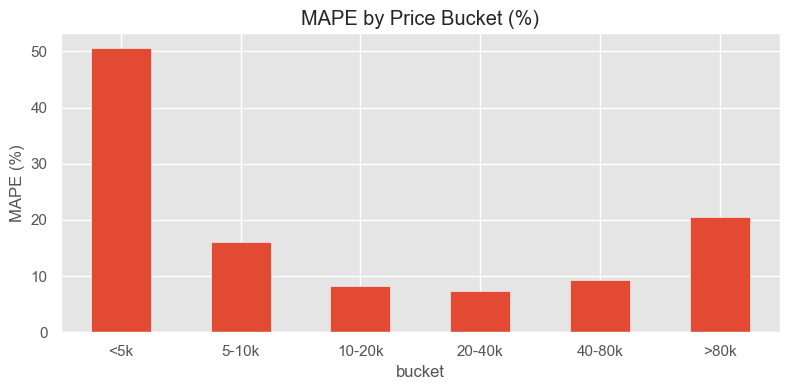

In [16]:
# ---- Error by price bucket ----
buckets = pd.cut(val_true, bins=[0, 5000, 10000, 20000, 40000, 80000, np.inf],
                 labels=['<5k','5-10k','10-20k','20-40k','40-80k','>80k'])
bucket_df = pd.DataFrame({'true': val_true, 'pred': val_pred, 'bucket': buckets})
bucket_df['APE'] = np.abs(bucket_df['true'] - bucket_df['pred']) / bucket_df['true'].replace(0, np.nan)

bucket_summary = bucket_df.groupby('bucket', observed=True)['APE'].agg(['mean','count'])
bucket_summary.columns = ['MAPE', 'Count']
bucket_summary['MAPE'] = (bucket_summary['MAPE'] * 100).round(1)

print('Error by price bucket:')
print(bucket_summary)

bucket_summary['MAPE'].plot(kind='bar', figsize=(8,4), title='MAPE by Price Bucket (%)', rot=0)
plt.ylabel('MAPE (%)')
plt.tight_layout()
plt.savefig('../logs/error_by_bucket.png', dpi=120)
plt.show()

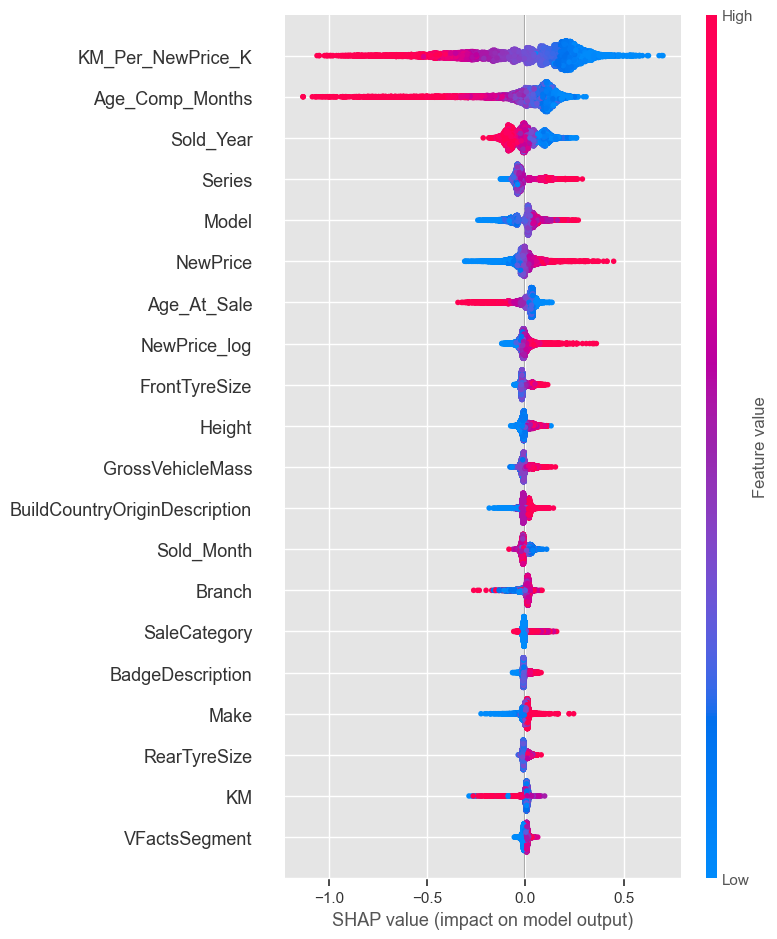

In [17]:
# Feature names must match ColumnTransformer order: num → low_card → high_card
feature_names = num_cols + low_card_cols + high_card_cols

X_val_transformed = best_pipe.named_steps['pre'].transform(X_val)

explainer   = shap.TreeExplainer(best_pipe.named_steps['model'])
shap_values = explainer.shap_values(X_val_transformed)

plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values, X_val_transformed,
    feature_names=feature_names, show=False, max_display=20,
)
plt.tight_layout()
plt.savefig('../logs/shap_summary.png', dpi=120)
plt.show()

In [18]:
# ── Align test columns to training columns ────────────────────────────
X_test = test_proc.reindex(columns=X.columns)

# ── Fit final ensemble on all training data (train + val) ─────────────
X_all = pd.concat([X_train, X_val])
y_all = pd.concat([y_train, y_val])

final_lgbm = Pipeline([
    ('pre',   preprocessor),
    ('model', LGBMRegressor(**best_lgbm_params, verbose=-1)),
])
final_xgb = Pipeline([
    ('pre',   preprocessor),
    ('model', MODELS['XGBoost']),
])

final_lgbm.fit(X_all, y_all)
final_xgb.fit(X_all, y_all)

test_pred_log = (
    w_lgbm * final_lgbm.predict(X_test)
    + w_xgb * final_xgb.predict(X_test)
)
test_predictions = np.expm1(test_pred_log)

# ── Build output: actual vs predicted ────────────────────────────────
submission = pd.DataFrame({
    'Actual_Sold_Amount':    test_proc[TARGET].values,
    'Predicted_Sold_Amount': test_predictions.round(2),
})
submission['Error']     = (submission['Predicted_Sold_Amount'] - submission['Actual_Sold_Amount']).round(2)
submission['Error_Pct'] = ((submission['Error'] / submission['Actual_Sold_Amount'].replace(0, np.nan)) * 100).round(1)

submission.to_csv('../logs/predictions.csv', index=True)
print(f'Predictions saved. Shape: {submission.shape}')
print(submission[['Actual_Sold_Amount', 'Predicted_Sold_Amount', 'Error', 'Error_Pct']].describe().round(2))

# ── True test set metrics ─────────────────────────────────────────────
from trainer import regression_metrics
mask = submission['Actual_Sold_Amount'].notna()
test_metrics = regression_metrics(
    np.log1p(submission.loc[mask, 'Actual_Sold_Amount'].values),
    np.log1p(submission.loc[mask, 'Predicted_Sold_Amount'].values),
)
print('\nTrue test set metrics (log-space):')
for k, v in test_metrics.items():
    print(f'  {k}: {v:.4f}')

Predictions saved. Shape: (11488, 4)
       Actual_Sold_Amount  Predicted_Sold_Amount      Error  Error_Pct
count            11488.00               11488.00   11488.00   11488.00
mean             18142.12               17901.71    -240.40       3.08
std              11392.16               10357.91    3447.08      30.70
min                185.00                 549.77 -161817.39     -97.80
25%              11200.00               11404.46   -1372.65      -8.30
50%              15750.00               16012.21      36.14       0.20
75%              22500.00               21984.94    1261.39       9.10
max             165450.00              123670.43   23670.43    1760.80

True test set metrics (log-space):
  MAE: 0.1253
  RMSE: 0.1915
  R2: 0.9090
  sMAPE: 1.3456
